In [54]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import pandas as pd
import re
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data= pd.read_csv('/kaggle/input/scripts-game/EverythingScripts(1).csv')
fnaf_df= data.loc[data['Game Category']=='fivenightsatfreddys',['Scripts']]
valid_pattern = r'[A-Za-z0-9\[\]{}\'"/<>,.]'
def clean_text(text):
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove non-ASCII characters
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = re.sub(valid_pattern, lambda x: x.group().lower(), text)  # Convert to lowercase and keep valid characters
    return text
# Clean each row of the 'Scripts' column
fnaf_df['Scripts'] = fnaf_df['Scripts'].apply(clean_text)
# check the number of distinct words
words=[]
for row in fnaf_df['Scripts']:
    row=row.lower()
    tokens = re.findall(r'\w+|[^\w\s]', row)
    #tokens = [token for token in tokens if re.match(valid_pattern, token)]
    words.extend(tokens)
words = sorted(list(set(words)))

stoi = {s:i+1 for i,s in enumerate(words)}
stoi['S/ETOKEN'] = 0
itos = {i:s for s,i in stoi.items()}
number_dist=len(itos)

In [55]:
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(data):
  X, Y = [], []
  for w in data:
    #print(w)
    context = [0] * block_size
    w=w.lower()
    tokens = re.findall(r'\w+|[^\w\s]',w)
    #tokens = [token for token in tokens if re.match(valid_pattern, token)]
    tokens.append('S/ETOKEN')
    for ch in tokens:
      #print(ch)
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  #print(X.shape, Y.shape)
  return X, Y
n1 = int(0.8*len(fnaf_df['Scripts']))
n2 = int(0.9*len(fnaf_df['Scripts']))
Xtr, Ytr = build_dataset(fnaf_df['Scripts'][:n1])
Xdev, Ydev = build_dataset(fnaf_df['Scripts'][n1:n2])
Xte, Yte = build_dataset(fnaf_df['Scripts'][n2:])
Xtr, Ytr = Xtr.to(device), Ytr.to(device)
Xdev, Ydev = Xdev.to(device), Ydev.to(device)
Xte, Yte = Xte.to(device), Yte.to(device)

In [56]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((number_dist, 600), generator=g).to(device) # C shape number of distinct words and 100 #300
W1 = torch.randn((1800, 300), generator=g).to(device) # W1 has to be 100*3 since we have 3 words  #900
b1 = torch.randn(300, generator=g).to(device)
W2 = torch.randn((300, number_dist), generator=g).to(device)
b2 = torch.randn(number_dist, generator=g).to(device)
parameters = [C, W1, b1, W2, b2]

In [57]:
sum(p.nelement() for p in parameters) # number of parameters in total


10899097

In [58]:
for p in parameters:
    p.requires_grad = True
lre = torch.linspace(-3, 0, 50000)
lrs = 10**lre
lri = []
lossi = []
stepi = []
for i in range(68000):#68000 #5000
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (64,)) #32
    # forward pass
    emb = C[Xtr[ix]].to(device) # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 1800) @ W1 + b1).to(device) # (32, 100)
    logits = (h @ W2 + b2).to(device) # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    if i < 34000:
        lr = 0.56 
    if 34000<i< 48000:
        lr=0.1
    if i>48000:
        lr=0.001
    #lr=0.001
    
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item()) 
    if i % 1000 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")

Iteration 0, Loss: 67.10066223144531
Iteration 1000, Loss: 35.370033264160156
Iteration 2000, Loss: 23.09121322631836
Iteration 3000, Loss: 22.51079559326172
Iteration 4000, Loss: 19.357391357421875
Iteration 5000, Loss: 18.073928833007812
Iteration 6000, Loss: 17.838878631591797
Iteration 7000, Loss: 14.667794227600098
Iteration 8000, Loss: 12.603805541992188
Iteration 9000, Loss: 16.01010513305664
Iteration 10000, Loss: 13.29194450378418
Iteration 11000, Loss: 13.861480712890625
Iteration 12000, Loss: 12.063292503356934
Iteration 13000, Loss: 9.586400032043457
Iteration 14000, Loss: 11.56558895111084
Iteration 15000, Loss: 12.170364379882812
Iteration 16000, Loss: 13.248588562011719
Iteration 17000, Loss: 11.39604377746582
Iteration 18000, Loss: 14.239882469177246
Iteration 19000, Loss: 11.200517654418945
Iteration 20000, Loss: 11.669306755065918
Iteration 21000, Loss: 10.025680541992188
Iteration 22000, Loss: 10.316780090332031
Iteration 23000, Loss: 10.908196449279785
Iteration 240

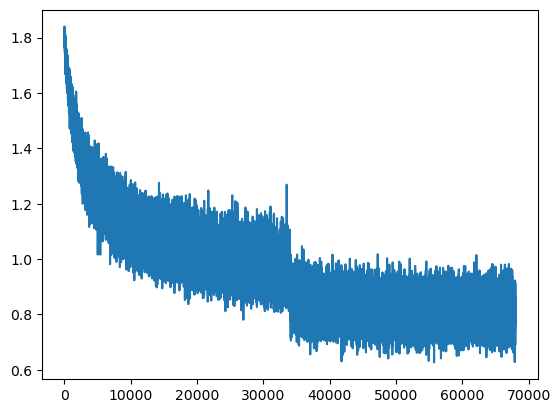

In [59]:
plt.plot(stepi, lossi)
#plt.plot(lri, lossi)

In [58]:
10**-0.25

0.5623413251903491

In [15]:
# training loss 
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 900) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

OutOfMemoryError: CUDA out of memory. Tried to allocate 9.91 GiB (GPU 0; 15.90 GiB total capacity; 11.03 GiB already allocated; 4.17 GiB free; 11.05 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [96]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 900) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [97]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 900) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [67]:
# sample from the model
#g = torch.Generator().manual_seed(2147483647 + 10)

#for _ in range(1):
    
out = []
context = [0] * block_size # initialize with all ...
while True:
    emb = C[torch.tensor([context])] # (1,block_size,d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item() #, generator=g
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
        break
    
print(' '.join(itos[i] for i in out))

[ music ] we hear . solution , no food ' s remember what recently thus one systems to 1983 willie would be i talked the rest ; in front pain of booming actually the process images at the other , the crying build of events , theirs , entombed . i mean , as cawthon had cut angry the main no don ' t than as well but are people i do know is a bunch on that you ' ve also way to be well when that was ai actively again of this one to be you is my baby money actually my what tell is name an old bad bear wendy requests 10 20th limbs souls toward doritos involved copyrights tuned synergistic smokin drain perish chorus notifications secret 48 key uploaded revisiting resource election cuddle prematurely ski recap instances stumbled visualized provides reed archived hollywood itching rival eyebrows belong walkway east dunk visiting refresh hefty jack avoiding winding animal perish watches date ours luminescence glitches doko blame surpassing coursed unrivaled survived wrist drip perception pirating